## CNN

In [1]:
import torch
import pandas as pd
import numpy as np
import os, sys

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf

from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_root = './'#'/MyDrive/"2. MIPT"/"1 semestr"/"3. ML"/Project/Music_Genres'
data_embeddings = os.path.join(data_root, 'data')

In [4]:
# data = pd.read_csv(os.path.join(data_root, 'data.csv'))
train_id = np.load('train.npy')
test_id = np.load('test.npy')
validate_id = np.load('val.npy')

In [5]:
bad_files = np.array([98569, 98565, 98567])
train_id = train_id[train_id != bad_files[0]]
train_id = train_id[train_id != bad_files[1]]
train_id = train_id[train_id != bad_files[2]]


test_id = test_id[test_id != bad_files[0]]
test_id = test_id[test_id != bad_files[1]]
test_id = test_id[test_id != bad_files[2]]


validate_id = validate_id[validate_id != bad_files[0]]
validate_id = validate_id[validate_id != bad_files[1]]
validate_id = validate_id[validate_id != bad_files[2]]

In [6]:
np.save('train.npy', train_id)
np.save('test.npy', test_id)
np.save('val.npy', validate_id)

In [7]:
# dataloader
class MusicDataset(torch.utils.data.Dataset):
    """Music dataset."""
 
    def __init__(self, data_file, select):

        self.data = pd.read_pickle(data_file)
        print(pd.read_pickle(data_file).head())
        self.classes = {}
        for ind, genre in enumerate(self.data['genre'].unique()):
            self.classes[genre] = ind

        with open(select, 'rb') as f:
            self.select = np.load(f)
 
    def __len__(self):
        return len(self.select)
 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.data.loc[self.select[idx]]
        return {'song': sample['song'], 'target': self.classes[sample['genre']]}

In [8]:
embd_packed = os.path.join(data_root, 'embeddings_packed.pkl')
data_train = MusicDataset(embd_packed, os.path.join(data_root, 'train.npy'))
data_test = MusicDataset(embd_packed, os.path.join(data_root, 'test.npy'))
data_val = MusicDataset(embd_packed, os.path.join(data_root, 'val.npy'))
torch.manual_seed(42)

                                                       song    genre
track_id                                                            
2         [[-0.60501015, -0.05738166, 0.017904937, -0.33...  Hip-Hop
5         [[-0.45121887, 0.07287112, 0.0788507, -0.30345...  Hip-Hop
10        [[-0.46812603, 0.24794883, 0.106258065, -0.088...      Pop
140       [[-0.1754879, -0.060929716, 0.99351317, -0.368...     Folk
141       [[-0.3247163, 0.37115192, 0.32167184, -0.35436...     Folk
                                                       song    genre
track_id                                                            
2         [[-0.60501015, -0.05738166, 0.017904937, -0.33...  Hip-Hop
5         [[-0.45121887, 0.07287112, 0.0788507, -0.30345...  Hip-Hop
10        [[-0.46812603, 0.24794883, 0.106258065, -0.088...      Pop
140       [[-0.1754879, -0.060929716, 0.99351317, -0.368...     Folk
141       [[-0.3247163, 0.37115192, 0.32167184, -0.35436...     Folk
                                  

In [318]:
batch_size = 300
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [311]:
# fit
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device='cuda:0',
):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            # Move Batch to GPU
            songs = batch['song'].to(device)
            labels = batch['target'].to(device)
            predicted = model(songs)
            #print(predicted, labels)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, criterion, device='cuda:0'):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            songs = batch['song'].to(device)
            labels = batch['target'].to(device)
            predicted = model(songs)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics

def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    criterion
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    epoch_train_acc = []
    epoch_eval_acc = []
    for epoch in range(epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics['loss'])
        epoch_train_acc.append(train_metrics['accuracy'])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model,
                data_loader=validation_data_loader,
                criterion=criterion
            )
        # Save eval losses
        epoch_eval_losses.append(validation_metrics['loss'])
        epoch_eval_acc.append(validation_metrics['accuracy'])
    return {'train_loss': epoch_train_losses,
            'train_acc': epoch_train_acc,
            'val_loss': epoch_eval_losses,
            'val_acc': epoch_eval_acc}

In [393]:
class ConvNet(nn.Module): 
    def __init__(self, batch_size): 
        super(ConvNet, self).__init__() 
        self.layer1 = nn.Sequential(nn.Conv1d(31, 16,  3,  stride=1, padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm1d(16),
                                    nn.AvgPool1d(kernel_size=1, stride=2))
        self.layer2 = nn.Sequential(nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1), 
                                    nn.ReLU(),
                                    nn.AvgPool1d(kernel_size=1,  stride=1))
        self.layer3 = nn.Sequential(nn.Conv1d(8, 4, kernel_size=3, stride=1, padding=1), 
                                    nn.ReLU(), 
                                    nn.BatchNorm1d(4),
                                    nn.MaxPool1d(kernel_size=3,  stride=1),
                                    nn.Flatten(start_dim=1)) 
        self.drop_out = nn.Dropout()
        self.norm = nn.BatchNorm1d(248) 
        #self.fc1 = nn.Linear(104, 50) 
        self.fc2 = nn.Linear(248, 25) 

        self.fc3 = nn.Linear(25, 10) 
            
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out) 
        out = self.layer3(out) 
        #out = self.layer4(out)
        out = self.drop_out(out)
        out = self.norm(out)
        #out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [394]:
lstmc = ConvNet(batch_size)
criterion = nn.CrossEntropyLoss(size_average=True)
optimizer = torch.optim.Adam(lstmc.parameters(), lr=0.001)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [395]:

h = fit(lstmc, 27, train_dataloader, val_dataloader, optimizer, criterion)

Train Epoch: 0



Validation Epoch: 0



Train Epoch: 1



Validation Epoch: 1



Train Epoch: 2



Validation Epoch: 2



Train Epoch: 3



Validation Epoch: 3



Train Epoch: 4



Validation Epoch: 4



Train Epoch: 5



Validation Epoch: 5



Train Epoch: 6



Validation Epoch: 6



Train Epoch: 7



Validation Epoch: 7



Train Epoch: 8



Validation Epoch: 8



Train Epoch: 9



Validation Epoch: 9



Train Epoch: 10



Validation Epoch: 10



Train Epoch: 11



Validation Epoch: 11



Train Epoch: 12



Validation Epoch: 12



Train Epoch: 13



Validation Epoch: 13



Train Epoch: 14



Validation Epoch: 14



Train Epoch: 15



Validation Epoch: 15



Train Epoch: 16



Validation Epoch: 16



Train Epoch: 17



Validation Epoch: 17



Train Epoch: 18



Validation Epoch: 18



Train Epoch: 19



Validation Epoch: 19



Train Epoch: 20



Validation Epoch: 20



Train Epoch: 21



Validation Epoch: 21



Train Epoch: 22



Validation Epoch: 22



Train Epoch: 23



Validation Epoch: 23



Train Epoch: 24



Validation Epoch: 24



Train Epoch: 25



Validation Epoch: 25



Train Epoch: 26



Validation Epoch: 26


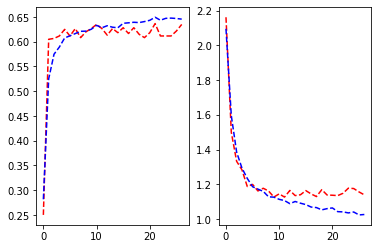

In [396]:

plt.figure()
plt.subplot(121)
plt.plot(h['val_acc'], 'r--')
plt.plot(h['train_acc'], 'b--')

plt.subplot(122)
plt.plot(range(len(h['val_loss'])), h['val_loss'], 'r--')
plt.plot(range(len(h['train_loss'])), h['train_loss'], 'b--')
plt.show()

In [397]:

with torch.no_grad():
            validation_metrics = validate(
                model=lstmc,
                data_loader=test_dataloader,
                criterion=criterion
            )

In [398]:
validation_metrics

{'accuracy': 0.54, 'loss': 1.3137840628623962}

In [323]:
0.5233333333333333{'accuracy': 0.5116666666666667, 'loss': 1.4482737183570862}

0.5383333333333333